In [1]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'PUJMZf9PLqN4y-6NUtVlEuq6zFoWhfuecFVMYLBrkxrT',
    'service_id': 'iam-ServiceId-9cd8e66e-3bb4-495a-807a-588692cca4d0',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_b0f1407510994fd1b793b85137baafb8_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191128183328-0000
KERNEL_ID = 9dd3f549-bb64-4724-b468-ae9793a8d737


In [2]:
df = spark.read.parquet(cos.url('washing.parquet', 'courseradsnew-donotdelete-pr-1hffrnl2pprwut'))
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [3]:
df.count()

2058

In [4]:
df.createOrReplaceTempView("washing")
spark.sql("select * from washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [5]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row: row.voltage).sample(False, 0.1).collect()
result_array[1:5]

[226, 227, 224, 225]

In [6]:
%matplotlib inline

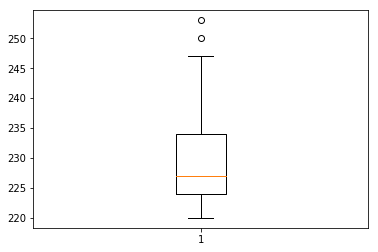

In [7]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [14]:
result = spark.sql("select voltage, ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False, 0.1).map(lambda row: (row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:10])
print(result_array_voltage[:10])

[1547808734922, 1547808770939, 1547808791957, 1547808794957, 1547808824978, 1547808827980, 1547808846029, 1547808879044, 1547808882045, 1547808915092]
[234, 239, 238, 224, 237, 224, 233, 220, 234, 238]


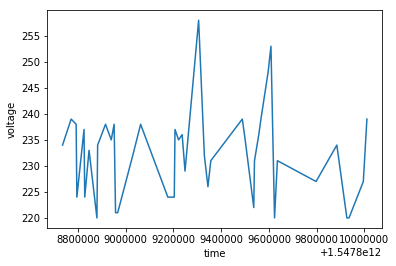

In [15]:
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

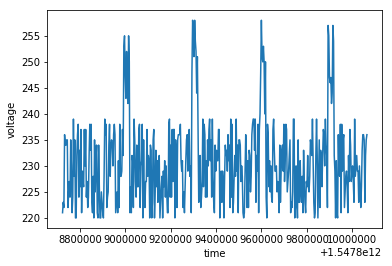

In [16]:
result = spark.sql(
"""
select voltage, ts from washing 
    where voltage is not null and
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
    """
)
result_rdd = result.rdd.map(lambda row:(row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

plot a 3D scatter plot.

In [20]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

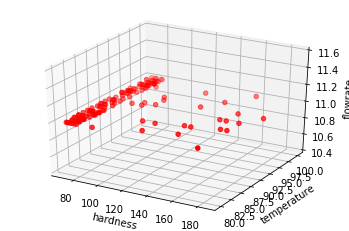

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(result_array_hardness, result_array_temperature, result_array_flowrate, c = 'r', marker = 'o'
    )
ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

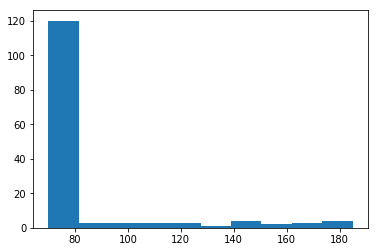

In [23]:
plt.hist(result_array_hardness)
plt.show()